# Disperser transmission study for HD205905


Study the true transmission wrt transmission in simulatio 

- author Sylvie Dagoret-Campagne
- creation date : May 2018
- affliliation : CNRS/IN2P3
- project : DESC-LSST

- need to increase the number of files to be open:

    ulimit -a
    
    ulimit -n 2048
    
    ulimit -Sn 10000

In [111]:
!ulimit -a

core file size          (blocks, -c) 0
data seg size           (kbytes, -d) unlimited
file size               (blocks, -f) unlimited
max locked memory       (kbytes, -l) unlimited
max memory size         (kbytes, -m) unlimited
open files                      (-n) 2048
pipe size            (512 bytes, -p) 1
stack size              (kbytes, -s) 8192
cpu time               (seconds, -t) unlimited
max user processes              (-u) 1418
virtual memory          (kbytes, -v) unlimited


## Setup

### Notebook style

In [112]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

### import

In [113]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
import sys
import os
import pandas as pd
import glob
from matplotlib.backends.backend_pdf import PdfPages 

In [114]:
from scipy import interpolate

In [115]:
import seaborn as sns

In [116]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Figure style

In [117]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),   #defines the default image size
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [118]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

## Initialisation

### Spectractor

In [119]:
PATH_SPECTRACTOR='../../../Spectractor'
PATH_SPECTRACTORSIM='../../../SpectractorSim'
PATH_SPECTRACTORANAATM='../../../SpectractorAnaAtm/common_tools'
PATH_GMAOMERRA='../../../merra2'

In [120]:
sys.path.append(PATH_SPECTRACTOR)
sys.path.append(PATH_SPECTRACTORSIM)
sys.path.append(PATH_SPECTRACTORANAATM)
sys.path.append(PATH_GMAOMERRA)

In [121]:
from spectractor import *
from spectractorsim import *
from libspecana import *

## Input spectra

### LogBook

In [122]:
file_logbook_csv=os.path.join(PATH_SPECTRACTOR,'ctiofulllogbook_jun2017_v4.csv')

In [123]:
df_ctio_lbk=pd.read_csv(file_logbook_csv,sep=';')

In [124]:
df_ctio_lbk.columns

Index([u'Unnamed: 0', u'date', u'subdir', u'index', u'object', u'filter',
       u'disperser', u'airmass', u'exposure', u'focus', u'seeing', u'P', u'T',
       u'RH', u'W', u'file', u'Obj-posXpix', u'Obj-posYpix', u'Dx', u'Dy',
       u'comment', u'skip'],
      dtype='object')

In [125]:
df_ctio_lbk=df_ctio_lbk.reindex(columns=['date','index','P','T','RH','airmass','seeing','exposure','object','filter','disperser','focus','W','subdir','file']).set_index('date').sort_index()

### Spectra Data

In [126]:
home=os.getenv('HOME')

In [127]:
path_data=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1')
#path_data=os.path.join('/sps/lsst/data/AtmosphericCalibration','CTIODataJune2017_reduced_RG715_v2_prod1')

In [128]:
All_Subdirs=np.array(['data_28may17','data_29may17','data_30may17','data_31may17','data_01jun17','data_02jun17',
            'data_03jun17','data_04jun17','data_06jun17','data_08jun17','data_09jun17','data_10jun17',
            'data_12jun17','data_13jun17'])

In [129]:
Flag_Photometric_Nights=np.array([False,False,True,False,False,False,False,False,False,True,False,True,True,False])

In [130]:
photometric_indexes=np.where(Flag_Photometric_Nights)[0]

In [131]:
print 'Photometric indexes : ',photometric_indexes

Photometric indexes :  [ 2  9 11 12]


In [132]:
print 'Photometric nights : ',All_Subdirs[photometric_indexes]

Photometric nights :  ['data_30may17' 'data_08jun17' 'data_10jun17' 'data_12jun17']


### Sim spectra

In [133]:
PATH_SPECTRACTORSIM

'../../../SpectractorAnaAtm/common_tools/../../SpectractorSim'

In [134]:
# laptop:
path_sim=os.path.join(PATH_SPECTRACTORSIM,'sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')
# CCIN2P3:
#path_sim=PATH_SPECTRACTORSIM+'/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'
# Office desktop
home=os.getenv('HOME')
path_sim=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2')

In [135]:
path_sim

'/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2'

## Selection of night

In [136]:
date="20170612"

In [137]:
idx_sel_subdir=12

In [138]:
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

### Logbook

In [139]:
all_obs=df_ctio_lbk.loc[(df_ctio_lbk["subdir"]==All_Subdirs[idx_sel_subdir])].sort_index()

In [140]:
all_obs_extr=all_obs[["index","object"]]

### Wavelength correction

In [141]:
FLAG_WL_CORRECTION=True # specify if correction on wavelength can be performed from input file
file_wavelengthshift="../wavelength_shift.csv"
wlshift=pd.read_csv(file_wavelengthshift)

In [142]:
wlshift.head()

,index,wlshift
0,51,7.0
1,52,1.0
2,53,2.0
3,54,-1.0
4,55,4.0


### path for spectra

In [143]:
path_spectra=os.path.join(path_data,All_Subdirs[idx_sel_subdir])
path_spectrasim=os.path.join(path_sim,All_Subdirs[idx_sel_subdir])

### find filename for data spectra

In [144]:
search_string=os.path.join(path_spectra,'*.fits')
all_spectrafiles=glob.glob(search_string)
all_spectrafiles=sorted(all_spectrafiles)

### extract the index from the data spectra filename

In [145]:
#SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
all_sel_indexes=[]
for ffn in all_spectrafiles:
    all_sel_indexes.append(get_index_from_filename(ffn,SelectTagRe))
all_sel_indexes=np.array(all_sel_indexes)    

### extract the logbook rows corrsponding to the spectra

- use the indexes obtained to extract the relevant rows from the logbook

In [146]:
sel_obs=all_obs.loc[all_obs['index'].isin(all_sel_indexes)]

In [147]:
sel_obs.head()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-06-13T00:24:20.451,41,779,"10,8",0,"1,239","0,792",600,PKS1510-089,dia,HoloPhP,12300,"12,3",data_12jun17,reduc_20170612_041.fits
2017-06-13T00:58:25.646,42,779,"10,5",31,"1,156","0,892",3600,PKS1510-089,dia,HoloPhP,12300,"13,1",data_12jun17,reduc_20170612_042.fits
2017-06-13T02:23:08.847,44,779,"9,7",0,"1,072","1,042",3600,PKS1510-089,dia,HoloPhAg,12300,"14,4",data_12jun17,reduc_20170612_044.fits
2017-06-13T06:12:16.748,48,779,"9,3",0,"1,051","1,049",30,HD160617,FGB37,Thor300,12400,19,data_12jun17,reduc_20170612_048.fits
2017-06-13T06:13:39.453,49,779,"9,2",0,"1,052","1,049",30,HD160617,FGB37,HoloPhP,12400,"19,7",data_12jun17,reduc_20170612_049.fits


In [148]:
sel_obs.tail()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-06-13T09:55:56.351,175,778,"9,2",30,"1,868","1,049",60,HD185975,FGB37,HoloAmAg,12400,"27,1",data_12jun17,reduc_20170612_175.fits
2017-06-13T09:58:23.806,176,778,"9,1",30,"1,031","1,049",30,HD205905,FGB37,Thor300,12400,"26,1",data_12jun17,reduc_20170612_176.fits
2017-06-13T09:59:46.505,177,778,"9,2",30,"1,032","1,049",30,HD205905,FGB37,HoloPhP,12400,"24,4",data_12jun17,reduc_20170612_177.fits
2017-06-13T10:01:09.099,178,778,"9,3",0,"1,033","1,049",60,HD205905,FGB37,HoloPhAg,12400,20,data_12jun17,reduc_20170612_178.fits
2017-06-13T10:03:01.553,179,778,9,0,"1,035","1,049",60,HD205905,FGB37,HoloAmAg,12400,"19,8",data_12jun17,reduc_20170612_179.fits


### Quick view on the kind of sources

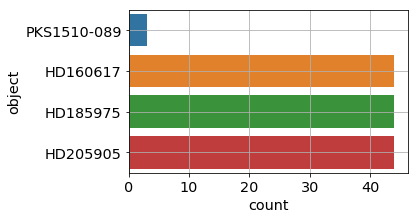

In [149]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel_obs)
plt.grid(True)

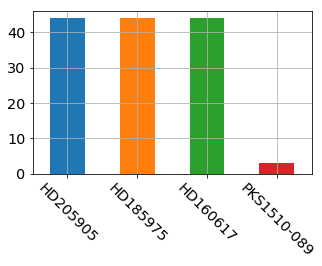

In [150]:
plt.figure(figsize=(5,3))
sel_obs['object'].value_counts().plot(kind='bar',rot=0)
plt.xticks(rotation=-45)
plt.grid(True)

### Remove bad spectra

In [151]:
bad_calib_indexes=np.array([48,49,50,168])

In [152]:
file_toremove=[]
#SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_calib_indexes:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_spectrafiles.remove(f) 

 remove  reduc_20170612_048_spectrum.fits
 remove  reduc_20170612_049_spectrum.fits
 remove  reduc_20170612_050_spectrum.fits
 remove  reduc_20170612_168_spectrum.fits


### Remove bad sources

- remove star **'PKS1510-089'**

In [153]:
bad_obs=sel_obs.loc[sel_obs['object'].isin(['PKS1510-089','HD185975','HD160617'])]
bad_indexes=bad_obs["index"]

In [154]:
bad_obs

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-06-13T00:24:20.451,41,779,"10,8",0,"1,239","0,792",600,PKS1510-089,dia,HoloPhP,12300,"12,3",data_12jun17,reduc_20170612_041.fits
2017-06-13T00:58:25.646,42,779,"10,5",31,"1,156","0,892",3600,PKS1510-089,dia,HoloPhP,12300,"13,1",data_12jun17,reduc_20170612_042.fits
2017-06-13T02:23:08.847,44,779,"9,7",0,"1,072","1,042",3600,PKS1510-089,dia,HoloPhAg,12300,"14,4",data_12jun17,reduc_20170612_044.fits
2017-06-13T06:12:16.748,48,779,"9,3",0,"1,051","1,049",30,HD160617,FGB37,Thor300,12400,19,data_12jun17,reduc_20170612_048.fits
2017-06-13T06:13:39.453,49,779,"9,2",0,"1,052","1,049",30,HD160617,FGB37,HoloPhP,12400,"19,7",data_12jun17,reduc_20170612_049.fits
2017-06-13T06:15:01.845,50,779,"9,2",34,"1,053","1,049",60,HD160617,FGB37,HoloPhAg,12400,"19,7",data_12jun17,reduc_20170612_050.fits
2017-06-13T06:16:54.310,51,779,"9,4",32,"1,055","1,049",60,HD160617,FGB37,HoloAmAg,12400,"21,5",data_12jun17,reduc_20170612_051.fits
2017-06-13T06:19:16.548,52,779,"9,4",35,"1,859","1,049",30,HD185975,FGB37,Thor300,12400,"19,9",data_12jun17,reduc_20170612_052.fits
2017-06-13T06:20:39.151,53,779,"9,3",32,"1,859","1,049",30,HD185975,FGB37,HoloPhP,12400,21,data_12jun17,reduc_20170612_053.fits


In [155]:
bad_indexes=bad_obs.loc[:,"index"]

In [156]:
bad_indexes.index

Index([u'2017-06-13T00:24:20.451', u'2017-06-13T00:58:25.646',
       u'2017-06-13T02:23:08.847', u'2017-06-13T06:12:16.748',
       u'2017-06-13T06:13:39.453', u'2017-06-13T06:15:01.845',
       u'2017-06-13T06:16:54.310', u'2017-06-13T06:19:16.548',
       u'2017-06-13T06:20:39.151', u'2017-06-13T06:22:01.796',
       u'2017-06-13T06:23:55.102', u'2017-06-13T06:33:28.449',
       u'2017-06-13T06:34:50.948', u'2017-06-13T06:36:13.605',
       u'2017-06-13T06:38:06.146', u'2017-06-13T06:40:27.614',
       u'2017-06-13T06:41:50.160', u'2017-06-13T06:43:13.459',
       u'2017-06-13T06:45:06.153', u'2017-06-13T06:54:40.297',
       u'2017-06-13T06:56:02.954', u'2017-06-13T06:57:25.558',
       u'2017-06-13T06:59:18.002', u'2017-06-13T07:01:39.448',
       u'2017-06-13T07:03:02.004', u'2017-06-13T07:04:24.507',
       u'2017-06-13T07:06:17.146', u'2017-06-13T07:15:50.405',
       u'2017-06-13T07:17:12.897', u'2017-06-13T07:18:35.664',
       u'2017-06-13T07:20:28.149', u'2017-06-13T07:22:5

In [157]:
bad_indexes.values

array([ 41,  42,  44,  48,  49,  50,  51,  52,  53,  54,  55,  60,  61,
        62,  63,  64,  65,  66,  67,  72,  73,  74,  75,  76,  77,  78,
        79,  84,  85,  86,  87,  88,  89,  90,  91,  96,  97,  98,  99,
       100, 101, 102, 103, 108, 109, 110, 111, 112, 113, 114, 115, 120,
       121, 122, 123, 124, 125, 126, 127, 132, 133, 134, 135, 136, 137,
       138, 139, 144, 145, 146, 147, 148, 149, 150, 151, 156, 157, 158,
       159, 160, 161, 162, 163, 168, 169, 170, 171, 172, 173, 174, 175])

### Concatenate bad obs

In [158]:
#bad_obs=pd.concat([bad_obs,bad_obs_0])

In [159]:
bad_obs

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-06-13T00:24:20.451,41,779,"10,8",0,"1,239","0,792",600,PKS1510-089,dia,HoloPhP,12300,"12,3",data_12jun17,reduc_20170612_041.fits
2017-06-13T00:58:25.646,42,779,"10,5",31,"1,156","0,892",3600,PKS1510-089,dia,HoloPhP,12300,"13,1",data_12jun17,reduc_20170612_042.fits
2017-06-13T02:23:08.847,44,779,"9,7",0,"1,072","1,042",3600,PKS1510-089,dia,HoloPhAg,12300,"14,4",data_12jun17,reduc_20170612_044.fits
2017-06-13T06:12:16.748,48,779,"9,3",0,"1,051","1,049",30,HD160617,FGB37,Thor300,12400,19,data_12jun17,reduc_20170612_048.fits
2017-06-13T06:13:39.453,49,779,"9,2",0,"1,052","1,049",30,HD160617,FGB37,HoloPhP,12400,"19,7",data_12jun17,reduc_20170612_049.fits
2017-06-13T06:15:01.845,50,779,"9,2",34,"1,053","1,049",60,HD160617,FGB37,HoloPhAg,12400,"19,7",data_12jun17,reduc_20170612_050.fits
2017-06-13T06:16:54.310,51,779,"9,4",32,"1,055","1,049",60,HD160617,FGB37,HoloAmAg,12400,"21,5",data_12jun17,reduc_20170612_051.fits
2017-06-13T06:19:16.548,52,779,"9,4",35,"1,859","1,049",30,HD185975,FGB37,Thor300,12400,"19,9",data_12jun17,reduc_20170612_052.fits
2017-06-13T06:20:39.151,53,779,"9,3",32,"1,859","1,049",30,HD185975,FGB37,HoloPhP,12400,21,data_12jun17,reduc_20170612_053.fits


In [160]:
bad_obs.sort_values(by="index",inplace=True)

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [161]:
bad_indexes=bad_obs.loc[:,"index"]

In [162]:
bad_indexes.index

Index([u'2017-06-13T00:24:20.451', u'2017-06-13T00:58:25.646',
       u'2017-06-13T02:23:08.847', u'2017-06-13T06:12:16.748',
       u'2017-06-13T06:13:39.453', u'2017-06-13T06:15:01.845',
       u'2017-06-13T06:16:54.310', u'2017-06-13T06:19:16.548',
       u'2017-06-13T06:20:39.151', u'2017-06-13T06:22:01.796',
       u'2017-06-13T06:23:55.102', u'2017-06-13T06:33:28.449',
       u'2017-06-13T06:34:50.948', u'2017-06-13T06:36:13.605',
       u'2017-06-13T06:38:06.146', u'2017-06-13T06:40:27.614',
       u'2017-06-13T06:41:50.160', u'2017-06-13T06:43:13.459',
       u'2017-06-13T06:45:06.153', u'2017-06-13T06:54:40.297',
       u'2017-06-13T06:56:02.954', u'2017-06-13T06:57:25.558',
       u'2017-06-13T06:59:18.002', u'2017-06-13T07:01:39.448',
       u'2017-06-13T07:03:02.004', u'2017-06-13T07:04:24.507',
       u'2017-06-13T07:06:17.146', u'2017-06-13T07:15:50.405',
       u'2017-06-13T07:17:12.897', u'2017-06-13T07:18:35.664',
       u'2017-06-13T07:20:28.149', u'2017-06-13T07:22:5

In [163]:
bad_indexes.values

array([ 41,  42,  44,  48,  49,  50,  51,  52,  53,  54,  55,  60,  61,
        62,  63,  64,  65,  66,  67,  72,  73,  74,  75,  76,  77,  78,
        79,  84,  85,  86,  87,  88,  89,  90,  91,  96,  97,  98,  99,
       100, 101, 102, 103, 108, 109, 110, 111, 112, 113, 114, 115, 120,
       121, 122, 123, 124, 125, 126, 127, 132, 133, 134, 135, 136, 137,
       138, 139, 144, 145, 146, 147, 148, 149, 150, 151, 156, 157, 158,
       159, 160, 161, 162, 163, 168, 169, 170, 171, 172, 173, 174, 175])

- keep stars **HD185975**

In [164]:
sel2_obs=sel_obs.loc[sel_obs['object'].isin(['HD205905'])]


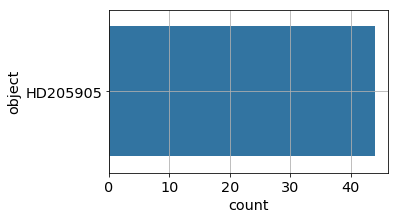

In [165]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel2_obs)
plt.grid(True)

#### Make a list of the object names

In [166]:
list_of_objects=sel2_obs['object'].values

In [167]:
list_of_objects=set(list_of_objects)

In [168]:
list_of_objects=list(list_of_objects)

In [169]:
list_of_objects_str=','.join(list_of_objects)

### find filename for sim spectra

In [170]:
path_sim1=os.path.join(path_spectrasim,'clearsky')
path_sim2=os.path.join(path_spectrasim,'standard')
path_sim3=os.path.join(path_spectrasim,'merra2')

In [171]:
search_string=os.path.join(path_sim1,'*.fits')
all_simspectrafiles1=glob.glob(search_string)
all_simspectrafiles1=sorted(all_simspectrafiles1)

In [172]:
all_simspectrafiles1[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_12jun17/clearsky/specsim_20170612_041_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_12jun17/clearsky/specsim_20170612_042_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_12jun17/clearsky/specsim_20170612_044_spectrum.fits']

In [173]:
search_string=os.path.join(path_sim2,'*.fits')
all_simspectrafiles2=glob.glob(search_string)
all_simspectrafiles2=sorted(all_simspectrafiles2)

In [174]:
all_simspectrafiles2[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_12jun17/standard/specsim_20170612_041_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_12jun17/standard/specsim_20170612_042_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_12jun17/standard/specsim_20170612_044_spectrum.fits']

In [175]:
search_string=os.path.join(path_sim3,'*.fits')
all_simspectrafiles3=glob.glob(search_string)
all_simspectrafiles3=sorted(all_simspectrafiles3)

In [176]:
all_simspectrafiles3[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_12jun17/merra2/specsim_20170612_041_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_12jun17/merra2/specsim_20170612_042_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_12jun17/merra2/specsim_20170612_044_spectrum.fits']

# Remove bad indexes

In [177]:
file_toremove=[]
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_spectrafiles.remove(f)        

 remove  reduc_20170612_041_spectrum.fits
 remove  reduc_20170612_042_spectrum.fits
 remove  reduc_20170612_044_spectrum.fits
 remove  reduc_20170612_051_spectrum.fits
 remove  reduc_20170612_052_spectrum.fits
 remove  reduc_20170612_053_spectrum.fits
 remove  reduc_20170612_054_spectrum.fits
 remove  reduc_20170612_055_spectrum.fits
 remove  reduc_20170612_060_spectrum.fits
 remove  reduc_20170612_061_spectrum.fits
 remove  reduc_20170612_062_spectrum.fits
 remove  reduc_20170612_063_spectrum.fits
 remove  reduc_20170612_064_spectrum.fits
 remove  reduc_20170612_065_spectrum.fits
 remove  reduc_20170612_066_spectrum.fits
 remove  reduc_20170612_067_spectrum.fits
 remove  reduc_20170612_072_spectrum.fits
 remove  reduc_20170612_073_spectrum.fits
 remove  reduc_20170612_074_spectrum.fits
 remove  reduc_20170612_075_spectrum.fits
 remove  reduc_20170612_076_spectrum.fits
 remove  reduc_20170612_077_spectrum.fits
 remove  reduc_20170612_078_spectrum.fits
 remove  reduc_20170612_079_spectr

In [178]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles1:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles1.remove(f)   

 remove  specsim_20170612_041_spectrum.fits
 remove  specsim_20170612_042_spectrum.fits
 remove  specsim_20170612_044_spectrum.fits
 remove  specsim_20170612_048_spectrum.fits
 remove  specsim_20170612_049_spectrum.fits
 remove  specsim_20170612_050_spectrum.fits
 remove  specsim_20170612_051_spectrum.fits
 remove  specsim_20170612_052_spectrum.fits
 remove  specsim_20170612_053_spectrum.fits
 remove  specsim_20170612_054_spectrum.fits
 remove  specsim_20170612_055_spectrum.fits
 remove  specsim_20170612_060_spectrum.fits
 remove  specsim_20170612_061_spectrum.fits
 remove  specsim_20170612_062_spectrum.fits
 remove  specsim_20170612_063_spectrum.fits
 remove  specsim_20170612_064_spectrum.fits
 remove  specsim_20170612_065_spectrum.fits
 remove  specsim_20170612_066_spectrum.fits
 remove  specsim_20170612_067_spectrum.fits
 remove  specsim_20170612_072_spectrum.fits
 remove  specsim_20170612_073_spectrum.fits
 remove  specsim_20170612_074_spectrum.fits
 remove  specsim_20170612_075_sp

In [179]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles2:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles2.remove(f)

 remove  specsim_20170612_041_spectrum.fits
 remove  specsim_20170612_042_spectrum.fits
 remove  specsim_20170612_044_spectrum.fits
 remove  specsim_20170612_048_spectrum.fits
 remove  specsim_20170612_049_spectrum.fits
 remove  specsim_20170612_050_spectrum.fits
 remove  specsim_20170612_051_spectrum.fits
 remove  specsim_20170612_052_spectrum.fits
 remove  specsim_20170612_053_spectrum.fits
 remove  specsim_20170612_054_spectrum.fits
 remove  specsim_20170612_055_spectrum.fits
 remove  specsim_20170612_060_spectrum.fits
 remove  specsim_20170612_061_spectrum.fits
 remove  specsim_20170612_062_spectrum.fits
 remove  specsim_20170612_063_spectrum.fits
 remove  specsim_20170612_064_spectrum.fits
 remove  specsim_20170612_065_spectrum.fits
 remove  specsim_20170612_066_spectrum.fits
 remove  specsim_20170612_067_spectrum.fits
 remove  specsim_20170612_072_spectrum.fits
 remove  specsim_20170612_073_spectrum.fits
 remove  specsim_20170612_074_spectrum.fits
 remove  specsim_20170612_075_sp

In [180]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles3:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles3.remove(f)

 remove  specsim_20170612_041_spectrum.fits
 remove  specsim_20170612_042_spectrum.fits
 remove  specsim_20170612_044_spectrum.fits
 remove  specsim_20170612_048_spectrum.fits
 remove  specsim_20170612_049_spectrum.fits
 remove  specsim_20170612_050_spectrum.fits
 remove  specsim_20170612_051_spectrum.fits
 remove  specsim_20170612_052_spectrum.fits
 remove  specsim_20170612_053_spectrum.fits
 remove  specsim_20170612_054_spectrum.fits
 remove  specsim_20170612_055_spectrum.fits
 remove  specsim_20170612_060_spectrum.fits
 remove  specsim_20170612_061_spectrum.fits
 remove  specsim_20170612_062_spectrum.fits
 remove  specsim_20170612_063_spectrum.fits
 remove  specsim_20170612_064_spectrum.fits
 remove  specsim_20170612_065_spectrum.fits
 remove  specsim_20170612_066_spectrum.fits
 remove  specsim_20170612_067_spectrum.fits
 remove  specsim_20170612_072_spectrum.fits
 remove  specsim_20170612_073_spectrum.fits
 remove  specsim_20170612_074_spectrum.fits
 remove  specsim_20170612_075_sp

# which filters

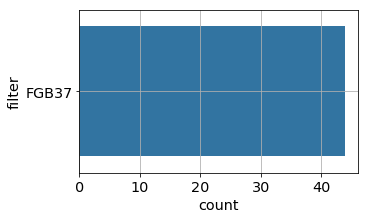

In [181]:
plt.figure(figsize=(5,3))
sns.countplot(y='filter', data=sel2_obs)
plt.grid(True)

# which are the dispersers ?

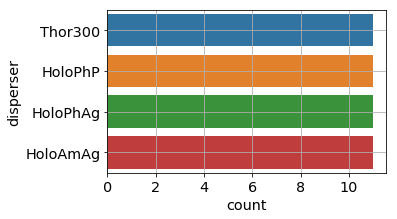

In [182]:
plt.figure(figsize=(5,3))
sns.countplot(y='disperser', data=sel2_obs)
plt.grid(True)

In [183]:
sel_obs_Ron400=sel2_obs.loc[sel2_obs['disperser'].isin(['Ron400'])]

In [184]:
sel_obs_Thor300=sel2_obs.loc[sel2_obs['disperser'].isin(['Thor300'])]

In [185]:
sel_obs_HoloPhP=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhP'])]

In [186]:
sel_obs_HoloPhAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhAg'])]

In [187]:
sel_obs_HoloAmAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloAmAg'])]

# Show the spectra

## Show the reconstructed spectra

In [188]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
print SearchTagRe

^reduc_20170612_([0-9]+)_spectrum.fits$


### Ronchi 400 spectra

In [189]:
#thetitle="Smoothed Reconstructed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

In [190]:
#PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### Thor 300

In [191]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

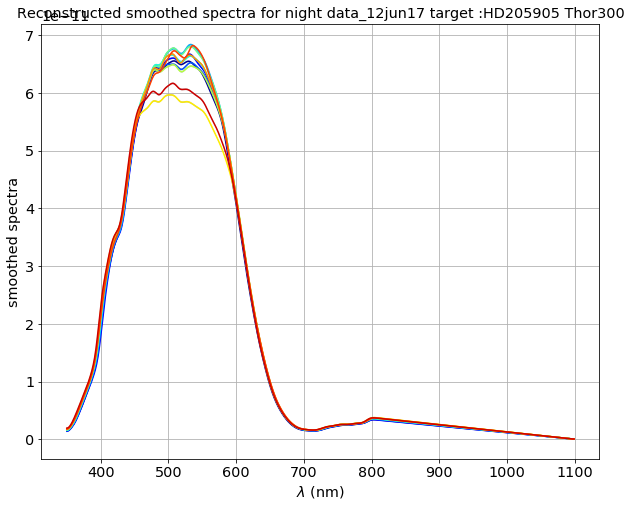

In [192]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### HoloPhP

In [193]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

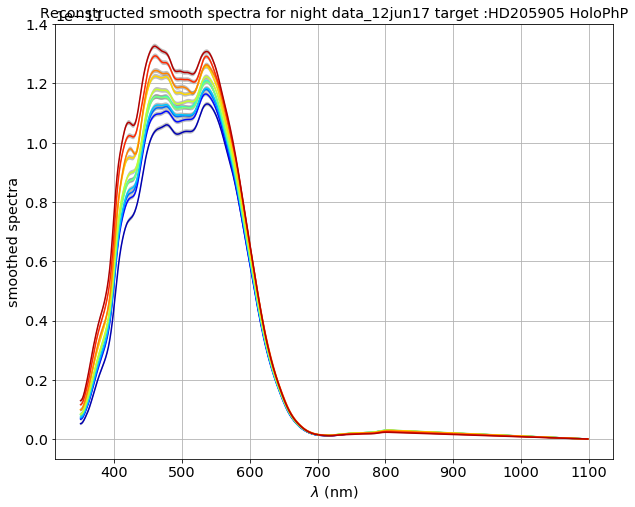

In [194]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### HoloPhAg

In [195]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

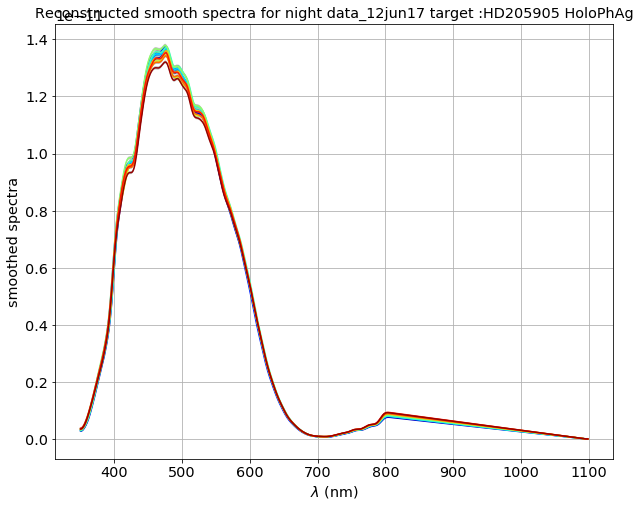

In [196]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### HoloAmAg

In [197]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

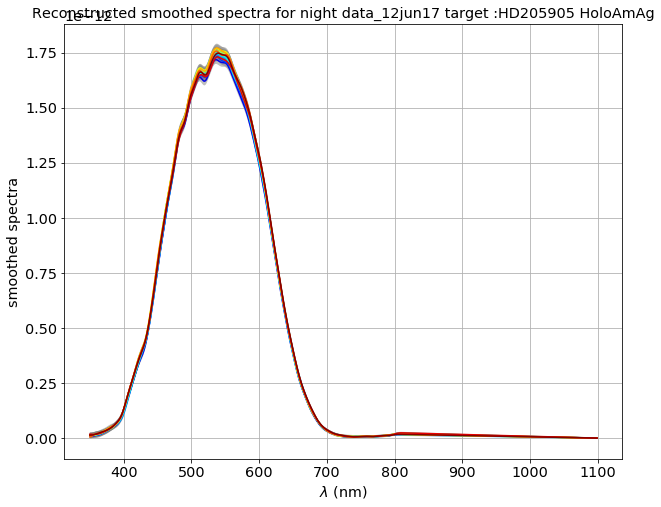

In [198]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

## Show the simulated spectra

In [199]:
SearchTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)

### Clear sky

In [200]:
thetitle="Smoothed sim spectra for night (clearsky) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

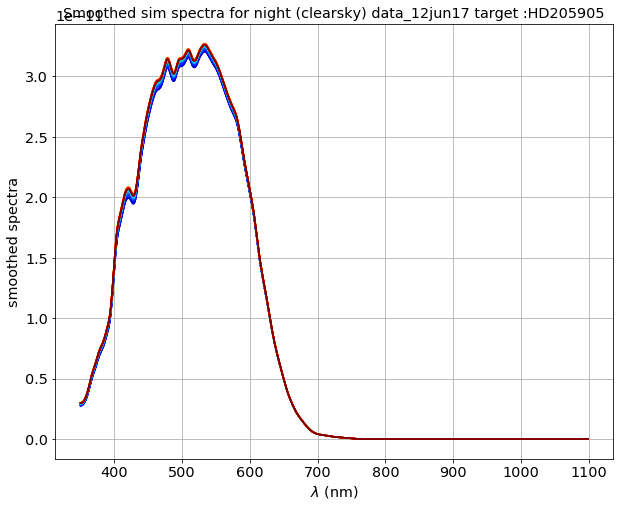

In [201]:
PlotSpectraDataSimSmooth(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False)

### standard sky

In [202]:
thetitle="Smoothed sim spectra for night (standard) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

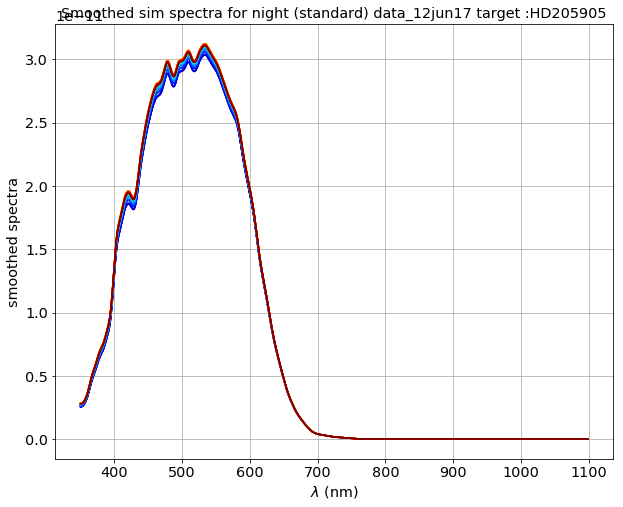

In [203]:
PlotSpectraDataSimSmooth(all_simspectrafiles2,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False)

### merra2 sky

In [204]:
thetitle="Smoothed sim spectra for night (merra2) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

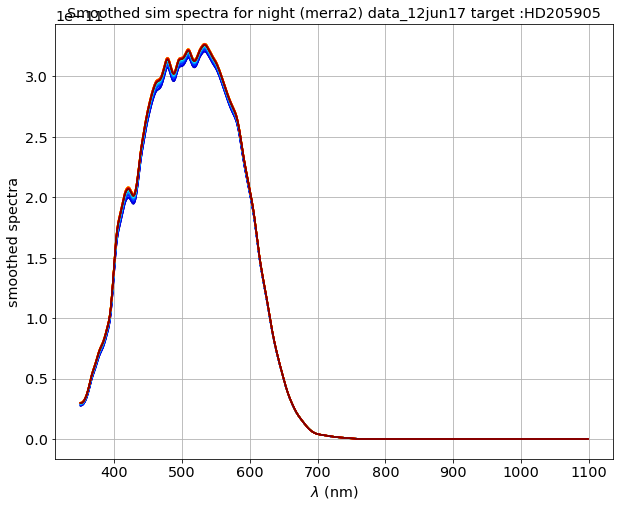

In [205]:
PlotSpectraDataSimSmooth(all_simspectrafiles3,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False)

# Spectra ratio data/sim

In [206]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

## spectra ratio for Ronchi 400

In [207]:
#thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

In [208]:
#PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,
#                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

In [209]:
#PlotSpectraLogRatioDataDivSimSmooth(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,
#                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

In [210]:
#the_ratio_file="ratiosmooth_Ron400.fits"
#arr=SaveSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,wlshift,the_ratio_file,FLAG_WL_CORRECTION,Flag_corr_wl=True)

In [211]:
#plt.imshow(arr[1:,:],cmap='jet')

## High order ratio for Thor300

In [212]:
thetitle="High order contamination for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

In [213]:
#PlotSpectraRatioHighOrderDataSimSmooth(all_spectrafiles,path_sim1,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=350,XMAX=650.,YMIN=0,YMAX=0)

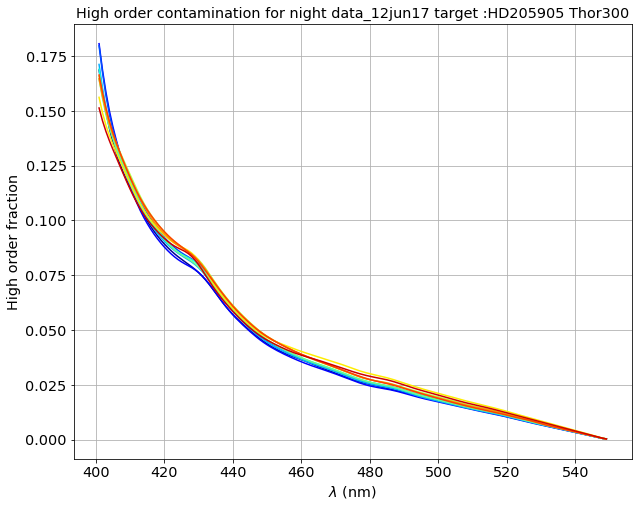

In [214]:
PlotSpectraRatioHighOrderDataSimSmooth(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=11)

## High order HoloPhP

In [215]:
#thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"
thetitle="High order contamination for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

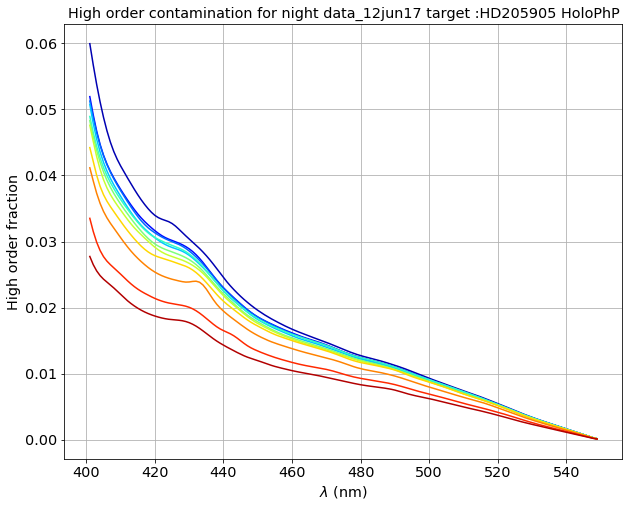

In [216]:
#PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,
#                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=350,XMAX=650.,YMIN=0,YMAX=0)
PlotSpectraRatioHighOrderDataSimSmooth(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=11)

## High order ratio for HoloPhAg

In [217]:
#thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"
thetitle="High order contamination for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

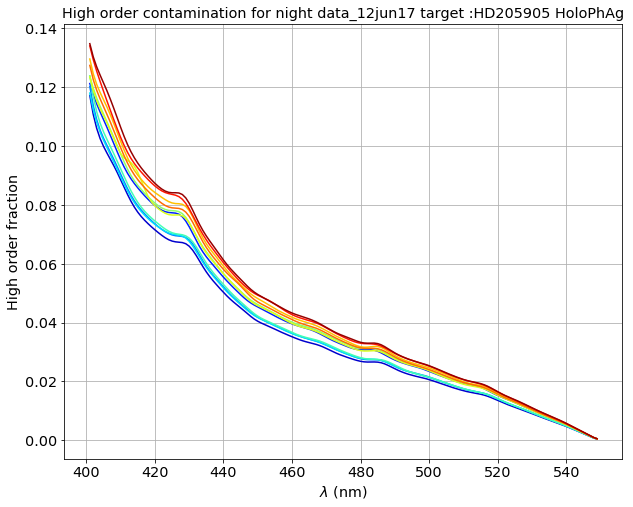

In [218]:
PlotSpectraRatioHighOrderDataSimSmooth(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=11)

## High order ratio for HoloAmAg

In [219]:
thetitle="High order contamination for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

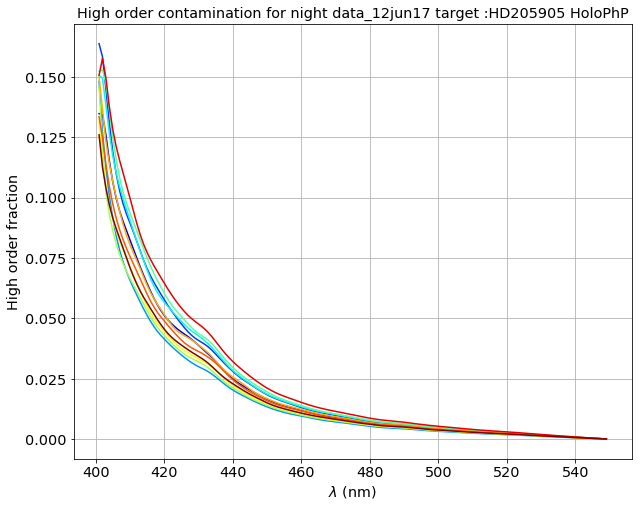

In [220]:
PlotSpectraRatioHighOrderDataSimSmooth(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=11)